In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
json_import = drive.CreateFile({'id':'1KpQKJnoX3XCpyW788srGxtO3nwZFJ4oE'})
json_import.GetContentFile('database.sqlite')
json_import = drive.CreateFile({'id':'1XRPgjWYDhIllbS4VWLGDIJ8-pcP7A_r4'})
json_import.GetContentFile('final.sqlite')

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
#using the SQLite table to read the data
con = sqlite3.connect('./database.sqlite')

#filtering only positive and negative reviews i.e 
#not taking into consideration those reviews with score = 3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3
""",con)
#filtered_data

In [0]:
#Give reviews with Score > 3 a positive rating, and reviews with score < 3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be negative and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Exploratory Data Analysis**

Data Depulication : Reviews table has many duplicate entries. Hence it is necessary to get remove duplicates in order to get unbaised results for analysis of the data

In [0]:
#Sorting Data according to Product ID in ascending order
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

#Deduplication of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

It was seen that value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from data set

In [0]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
print(final['Score'].value_counts())
final.head()

(364171, 10)
positive    307061
negative     57110
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


**Text PreProcessing**

In [0]:
#find sentences containing html tags
i=0
for text in final['Text'].values:
    if (len(re.findall("<.*?>",text))):
        print(i)
        print(text)
        break
    i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))  #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence):  #function to clean the words of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):  #function to clean the sentence for any punctuaution or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('****************************')
print(sno.stem('tasty'))

{'at', 'after', "should've", "she's", 'been', 'because', 'those', 'do', 'nor', 'being', 's', "isn't", 'than', 'any', 'your', 'same', "hasn't", "you've", 'them', 'who', 't', 'd', "mustn't", 'am', 'down', 'won', "you'd", 'haven', "you'll", 'against', 'this', 'again', 'yourselves', 'couldn', 'about', 'only', 'ain', "haven't", 'weren', 'mightn', 'during', 'has', 'our', 'it', 'be', 'a', 'shouldn', 'these', 'most', 'you', 'when', 'some', 'yours', 'were', 'yourself', 'over', "wouldn't", "needn't", 'how', 'ourselves', 'own', "shouldn't", 'myself', 'and', 'with', 'him', 'themselves', 'where', "didn't", 'if', 'then', 'doesn', 'himself', 'm', 'didn', 'in', 'each', 'just', 'o', 'shan', 'are', 'under', 'for', 'both', 'mustn', 'having', 'there', 'did', 'above', 'here', "don't", 'hasn', 'an', 'such', 'isn', 'off', 'theirs', 'hers', 'can', 'aren', "couldn't", 'herself', 'by', "mightn't", 'wasn', 'its', 'but', 'that', "aren't", 'not', 'was', 'doing', 'me', 'have', 'until', 'his', "that'll", 'which', 'w

In [0]:
#code for text-preprocessing

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText'] = final_string  #added a column CleanedText which displays the data after preprocessing of the review

In [0]:
#filter CleanedText to strip junk at both ends

i=0

for text in final['CleanedText']:
  text = str(text)
  text = text.rstrip("''")
  text = text.lstrip("b'")
  final['CleanedText'][i] = text
  i+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
#store the final table into SQLite database for future use
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,flavor=None,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)


In [0]:
#using the SQLite table to read the data
con = sqlite3.connect('./final.sqlite')

#filtering only positive and negative reviews i.e 
#not taking into consideration those reviews with score = 3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3
""",con)
#filtered_data

In [0]:
final_sampled = final.sample(1000)
#final_sampled.head(2)
#final

In [0]:
#sort according to timestamp

sort_final = final_sampled.sort_values('Time',ascending=True)
sort_final=sort_final.reset_index(drop=True)


In [0]:
#sort_final

pandas.core.frame.DataFrame

In [0]:
#extract corresponding score values 
score_arr = []
for score in sort_final['Score']:
  if score == 'positive':
    score_arr.append(1)
  elif score == 'negative':
    score_arr.append(0)


In [0]:
pos_c = 0
neg_c = 0
for i in score_arr:
  if i == 1:
    pos_c+=1
  elif i == 0:
    neg_c +=1

In [0]:
print(pos_c,neg_c)

842 158


In [0]:
#convert to a numpy array

score_np_arr = np.array(score_arr)
#len(score_np_arr)

#conver to DataFrame

score_df = pd.DataFrame(data=score_arr,columns=['Score'])


*Split* the data into train test and CV

In [0]:
#print(sort_final.columns)

reviews = sort_final[['Summary','CleanedText']]

#reviews.reset_index(drop=True,inplace=True)



In [0]:
i=0
#uniq_words_list=[]
for text in reviews['CleanedText']:
  text = str(text)
  text = text.rstrip("''")
  text = text.lstrip("b'")
  reviews['CleanedText'][i] = text
  i+=1
#  uniq_words_list.append(text)
 


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [0]:
#afr_train = pd.DataFrame(columns=['msg'])
#afr_test  = pd.DataFrame(columns=['msg'])

#per = len(reviews) * .80

#for i in range(len(reviews)):
#  if i < per:
#    afr_train=afr_train.append(pd.Series(reviews[i],index=['msg']),ignore_index=True)
#  elif i > per:
#    afr_test=afr_test.append(pd.Series(reviews[i],index=['msg']),ignore_index=True)
i=0
#k=[]
##for j in uniq_words_list:
 #   k.extend(j.split())

#print(len(k))
#uniq_k =set(k)
#print(len(uniq_k))
#print(uniq_k)

#Perform BOW

Make transtab

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
stemmer = PorterStemmer()
from nltk.corpus import stopwords
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
  
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)
  
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

In [0]:
#bow for summary
corpus_summary = []
reviews_list = []
for i in range(len(reviews)):
  reviews_list.append(reviews['Summary'][i])
for text in reviews_list:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus_summary.append(text)


In [0]:

k=[]
for j in corpus_summary:
    k.extend(j.split())
print(len(k))
uniq_k =set(k)
print(len(uniq_k))
#print(uniq_k)

4089
1185


In [0]:
#create vectors for summary columns using BOW without sklearn

from collections import Counter
summary_bow_l=[]

for i in corpus_summary:
    bow_l=[]
    l=i.split(' ')
#    print(l)
    counts = Counter(l)

    for word in uniq_k:
      if word in counts.keys():
        bow_l.append(counts[word])
      else:
        bow_l.append(0)
    summary_bow_l.append(bow_l)
    

        


In [0]:
#bow for CleanedText without sklearn
corpus_cleanedtext = []
reviews_list_cl = []
for i in range(len(reviews)):
  reviews_list_cl.append(reviews['CleanedText'][i])
for text in reviews_list_cl:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    corpus_cleanedtext.append(text)

In [0]:
k_ct=[]
for j_ct in corpus_cleanedtext:
    k_ct.extend(j_ct.split())
print(len(k_ct))
uniq_ct =set(k_ct)
print(len(uniq_ct))
#print(uniq_k)

39180
4550


In [0]:
#create vectors for CleanedText column using BOW without sklearn
from collections import Counter
ct_bow_l=[]

for i in corpus_cleanedtext:
    bow_l=[]
    l=i.split(' ')
#    print(l)
    counts = Counter(l)

    for word in uniq_ct:
      if word in counts.keys():
        bow_l.append(counts[word])
      else:
        bow_l.append(0)
    ct_bow_l.append(bow_l)

Finally obtained BOW vectors for Summary and CleanedText without sklearn

**summary_bow_l and ct_bow_l** bold text

In [0]:
#bow for summary using sklearn
count_vect = CountVectorizer()
bow_summary = count_vect.fit_transform(corpus_summary)

#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)



In [0]:
#bow for cleanedtext using sklearn
count_vect = CountVectorizer()
bow_cleanedtext = count_vect.fit_transform(corpus_cleanedtext)

In [0]:
#using sklearn
bow_summary_df = pd.DataFrame(bow_summary.toarray())
bow_cleanedtext_df = pd.DataFrame(bow_cleanedtext.toarray())


In [0]:
#without sklearm
bow_summary_arr_wskl = np.array(summary_bow_l)
bow_cleanedtext_arr_wskl = np.array(ct_bow_l)

(1000, 4550)

In [0]:
#using sklearn
clean_text_bow_arr = bow_cleanedtext_df.values
bow_summary_arr = bow_summary_df.values
l1=list(clean_text_bow_arr)
l2=list(bow_summary_arr)
#for el1,el2 in zip(l1,l2):
#    print(el1,el2)

In [0]:
merge = pd.DataFrame(columns=['summary','ct'])
l3=[]
#for el1,el2 in zip(l1,l2):
#    merge = merge.append({'summary':el1,'ct':el2},ignore_index=True)    
#    l3.append(el1.extend(el2))
for el1 in l1:
  for el2 in l2:
    l3.append(el1.extend(el2))
    

AttributeError: ignored

In [0]:
tr_np_arr = np.append(bow_summary_arr_wskl,bow_cleanedtext_arr_wskl,axis=1)
tr_np_arr.shape

#a=np.array([1,2,3],[7,8,9])
#b=np.array([4,5,6],[10,11,12])
#c=np.concatenate((a,b))
#print(clean_text_bow_arr.shape)
#clean_text_bow_arr




(1000, 5735)

In [0]:
bow_cleanedtext_arr_wskl.shape

(1000, 4550)

In [0]:
#Now split the BOW into test and train
#train_bow = bow_df.loc[0:799]
#test_bow = bow_df.loc[800:999]

#train_bow = merge.loc[0:799].values              #numpy array
#test_bow = merge.loc[800:999].values             #numpy array

train_bow = tr_np_arr[0:800]
test_bow = tr_np_arr[800:]

#train_bow = merge.loc[0:799]
#test_bow = merge.loc[800:999]


#train_bow = train_bow.ravel()   #to convert form 2d to 1d
#test_bow = test_bow.ravel()     #to convert from 2d to 1d

train_score = np.array(score_np_arr[0:800])
test_score = np.array(score_np_arr[800:])

#train_score = np.reshape(train_score, (-1, 2))  #to convert from 1d to 2d
#test_score = np.reshape(test_score, (-1, 2))  #to convert from 1d to 2d

In [0]:
  train_score.ndim

1

Initially I tried to split the data into train and test before applyig BOW. Found that Train BOW had 1009 features while test BOW had 407 features. So decided to split train and test after appyling BOW on whole reviews dataframe.

In [0]:
#for i in range(len(bow_df)):
bow_test_df.shape

(199, 407)

**10** fold cross validation


The optimal number of neighbors is 11.


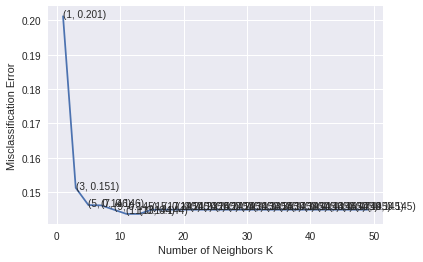

the misclassification error for each k value is :  [0.201 0.151 0.146 0.146 0.145 0.144 0.144 0.145 0.145 0.145 0.145 0.145
 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145 0.145
 0.145]


In [0]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_bow, train_score, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [0]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=7)

# fitting the model
knn_optimal.fit(train_bow, train_score)
summary_review = input('Enter a query summary review:')

#---------------BOW SUMMARY------------------------------------------------------------------#
#BOW for summary review without sklearn
from collections import Counter
q_summary_bow_l=[]

bow_l=[]
l=summary_review.split(' ')
#    print(l)
counts = Counter(l)

for word in uniq_k:
  if word in counts.keys():
    bow_l.append(counts[word])
  else:
    bow_l.append(0)
q_summary_bow_l.append(bow_l)
#-------------------BOW SUMMARY-------------------------------------------------------------#

#-----------------BOW CLEANEDTEXT-----------------------------------------------------------#
#BOW for CleanedText without sklearn
detail_review = input('Enter a detail review:')
q_ct_bow_l=[]

bow_l=[]
l=detail_review.split(' ')
#    print(l)
counts = Counter(l)

for word in uniq_ct:
  if word in counts.keys():
    bow_l.append(counts[word])
  else:
    bow_l.append(0)
q_ct_bow_l.append(bow_l)
#-----------------BOW CLEANEDTEXT-------------------------------------------------------------#

#----------merge summary and detail review-------------------------#
q_summary_arr_wskl = np.array(q_summary_bow_l)
q_detail_arr_wskl = np.array(q_ct_bow_l)
q_np_arr = np.append(q_summary_arr_wskl,q_detail_arr_wskl,axis=1)

# predict the response
#pred = knn_optimal.predict(test_bow)
pred=knn_optimal.predict(q_np_arr)

if pred == [1]:
  print('This is a postive review')
elif pred ==[0]:
  print('This is a negative review')

# evaluate accuracy
#acc = accuracy_score(test_score, pred) * 100
#print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

Enter a query summary review:bad product
Enter a detail review:product is very bad
This is a postive review


In [0]:
len(uniq_k)

1185

In [0]:
c=0

for i in range(len(test_score)):
  if test_score[i] == pred[i]:
    c+=1
    
print(c)
  
    

NameError: ignored

**Bag of Words (BoW)**

In [0]:
#BoW
import itertools
import scipy as sp
from scipy.sparse import csr_matrix
count_vect = CountVectorizer()  #in sckit learn
#final_counts = count_vect.fit_transform(final['Text'].values)
l=[]
#bow=sp.sparse.csr_matrix((0,0))
c=0
for text in final_sampled['Text']:
  while(c!=5):
    c+=1
    try:
      bow = count_vect.fit_transform([text])
#      print('bow:',bow)
    except ValueError:
#      c+=1
      print('ValueError:',c,text)
    bow_df = pd.DataFrame(bow.toarray())
#    print(bow)
    print(bow_df)
#    print(type(bow_df.values.tolist()))
    l.append(bow_df.values.tolist())
    #np_arr = bow_df.values.ravel()
    print(l)
    len=0
    for i in l:
      for j in i:    
        len+=1
    print('length:',len)
    #np.append(arr=final_np_arr,values=np_arr)
final_l=(list(itertools.chain(*l)))
#print(final_l)
final_np_arr = np.array(final_l)
print(final_np_arr.ndim)
#print(final_np_arr)
#print(final_np_arr.ndim)
#print(np_arr.ndim)
#print(np_arr)


   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0   1   1   1   1   1   1   1   1   2   1   1   1   2   1   1   1   1   1
[[[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]]]
length: 1
   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0   1   1   1   1   1   1   1   1   2   1   1   1   2   1   1   1   1   1
[[[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]], [[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]]]
length: 2
   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0   1   1   1   1   1   1   1   1   2   1   1   1   2   1   1   1   1   1
[[[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]], [[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]], [[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]]]
length: 3
   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0   1   1   1   1   1   1   1   1   2   1   1   1   2   1   1   1   1   1
[[[1, 1, 1, 1, 1, 1, 1, 1, 

In [0]:
#test
import itertools
list2d = [[[1,2,3]],[[4,5,6]], [[7]], [[8,9]]]
merged = list(itertools.chain(*list2d))
merged

[[1, 2, 3], [4, 5, 6], [7], [8, 9]]

In [0]:
final_np_arr

array([list([1, 1, 1, 1, 2, 1, 2, 2, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1]),
       list([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
       list([1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 3, 1, 1, 1, 2, 1, 1, 1]),
       list([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]),
       list([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
       list([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]),
       list([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1]),
       list([3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 

**K-NN on BOW**

In [0]:
#print(type(final_counts))
#print(final_counts.get_shape())
#print(final_counts)
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix

rev_list = []
rev_df = pd.DataFrame(columns=['Rev'])
#bow_df = pd.DataFrame(final_counts.toarray()) 
for score in final_sampled['Score']:
    if score  == 'positive':
      rev_list.append(1)
    else:
      rev_list.append(0)
np_arr_rev = np.array(rev_list)



#print(rev_list)

#neigh = KNeighborsClassifier(n_neighbors=10)
#revs=[]
#for score in final['Score']:
#    if score  == 'positive':
#        revs.append(1)
#    else:
#        revs.append(0)
#neigh.fit(final_counts,rev_n_arr.ravel()) 
#q_review = input('Enter a query review:')
#q=[q_review]
#q_review=count_vect.fit_transform(q)
#q_nparr= csr_matrix(q_review)
#q_nparr=q_nparr.todense()
#print(q_nparr)
#print(neigh.predict(q_nparr))
#if op == [0]:
#    print("Query review is a negative review")
#elif op == [1]:
#   print("Query review is a positive review")

In [0]:
neigh = KNeighborsClassifier(n_neighbors=10)

print((neigh.fit(final_np_arr,np_arr_rev)))
q_review = input('Enter a query review:')
q=[q_review]
q_review=count_vect.fit_transform(q)
bw_df = pd.DataFrame(q_review.toarray())
q_nparr = bw_df.values
#q_nparr= csr_matrix(q_review)
#q_nparr=q_nparr.todense()
print(q_nparr.ndim)
q_nparr=q_nparr.reshape(1,-1)
print(q_nparr.shape)
print(neigh.predict(q_nparr))

ValueError: ignored